---
### 2. 고객관점의 데이터 분석
- ARPU(Average Revenue Per User) : 가입한 서비스에 대해 가입자 1명이 특정 기간 동안 지출한 평균 금액
- ARPU = 매출 / 중복을 제외한 순수 활동 사용자 수
- ARPPU(Average Revenue Per Paying User): 지불 유저 1명 당 한 달에 결제하는 평균 금액을 산정한 수치
---

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
import datetime as dt 
import koreanize_matplotlib

In [2]:
## dataset loading 
import pyarrow as pa
import pyarrow.parquet as pq 

df_valid = pd.read_parquet('data/df_valid.parquet', engine='pyarrow') 
print(df_valid.shape)
df_valid.head(2)

(392692, 20)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_price,isRegistered,InvoiceCode,isCancel,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceDow,InvoiceTime,InvoiceHour,InvoiceYM,InvoceDayName
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,True,,False,2010,12,1,2,08:26:00,8,2010-12,수
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,True,,False,2010,12,1,2,08:26:00,8,2010-12,수


In [5]:
## ARPPU 구하기 : 월평균 유저당 매출금액 계산 
arppu = df_valid.groupby('InvoiceYM').agg({'Total_price':'sum',
                                           'CustomerID':'nunique'})
arppu['ARPPU'] = arppu['Total_price'] / arppu['CustomerID']

arppu

,Total_price,CustomerID,ARPPU
InvoiceYM,,,
2010-12,570422.730,885,644.545458
2011-01,568101.310,741,766.668435
2011-02,446084.920,758,588.502533
2011-03,594081.760,974,609.940205
2011-04,468374.331,856,547.166275
2011-05,677355.150,1056,641.434801
2011-06,660046.050,991,666.040414
2011-07,598962.901,949,631.151634
2011-08,644051.040,935,688.824642


[Text(0.5, 1.0, '월별 ARPPU')]

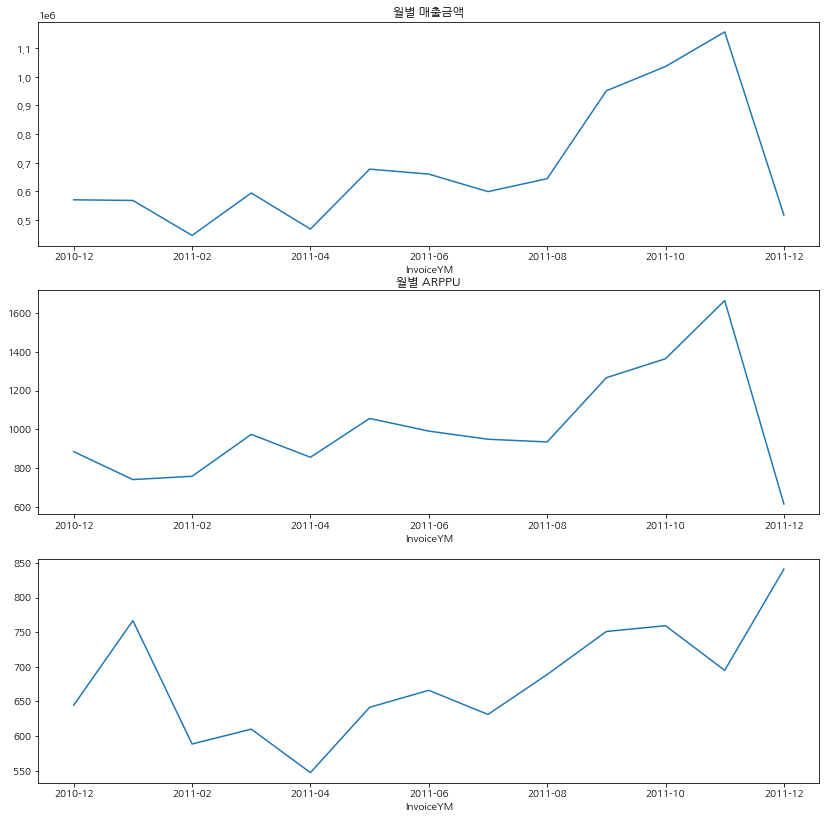

In [13]:
## 매출액과 고객수, ARPPU 시각화하여 비교 
figure, (ax1,ax2,ax3) = plt.subplots(nrows=3)
figure.set_size_inches(14,14)
arppu['Total_price'].plot(ax=ax1)
arppu['CustomerID'].plot(ax=ax2)
arppu['ARPPU'].plot(ax=ax3)
ax1.set(title = '월별 매출금액')
ax2.set(title = '월별 고객수')
ax2.set(title = '월별 ARPPU')

- 매출증감이 고객수의 영향을 크게 받고 있음 
- 한편 2010.1월, 2011.12월은 고객수&매출 감소에도 불구 ARPPU는 증가 

In [15]:
## 고객별 구매빈도, 평균 구매액, 합계 구매액 구하기 
cust_agg = df_valid.groupby('CustomerID').agg({'InvoiceNo':'count', 
                                               'Total_price':['mean', 'sum']})
cust_agg

InvoiceNo   Total_price          
               count          mean       sum
CustomerID                                  
12346.0            1  77183.600000  77183.60
12347.0          182     23.681319   4310.00
12348.0           31     57.975484   1797.24
12349.0           73     24.076027   1757.55
12350.0           17     19.670588    334.40
...              ...           ...       ...
18280.0           10     18.060000    180.60
18281.0            7     11.545714     80.82
18282.0           12     14.837500    178.05
18283.0          721      2.837074   2045.53
18287.0           70     26.246857   1837.28

[4338 rows x 3 columns]

In [16]:
cust_agg.describe()

InvoiceNo   Total_price               
             count          mean            sum
count  4338.000000   4338.000000    4338.000000
mean     90.523744     68.381590    2048.688081
std     225.506968   1467.918294    8985.230220
min       1.000000      2.136970       3.750000
25%      17.000000     12.393196     306.482500
50%      41.000000     17.755000     668.570000
75%      98.000000     24.878950    1660.597500
max    7676.000000  77183.600000  280206.020000

- 구매빈도 : 총 고객수는 4338명이며, 평균 90건을 구매했다. (최대 7천건 이상 구매도 있다) 
- 매출 : 인당 평균 매출 및 합계 매출은 약 68파운드 & 2048파운드 
- 구매빈도나 매출액 모두 극단적으로 높은 값들이 존재함 

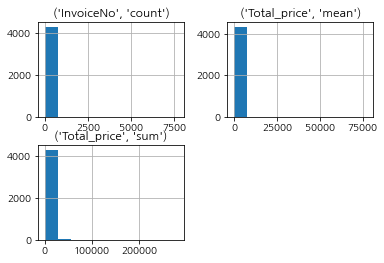

In [18]:
cust_agg.hist() ;

---
### 3. 월단위 분석 
- MAU(Monthly Active User)
---

InvoiceYM
2010-12     885
2011-01     741
2011-02     758
2011-03     974
2011-04     856
2011-05    1056
2011-06     991
2011-07     949
2011-08     935
2011-09    1266
2011-10    1364
2011-11    1664
2011-12     615
Name: CustomerID, dtype: int64


<AxesSubplot:title={'center':'MAU(Monthly Active Users)'}, xlabel='InvoiceYM'>

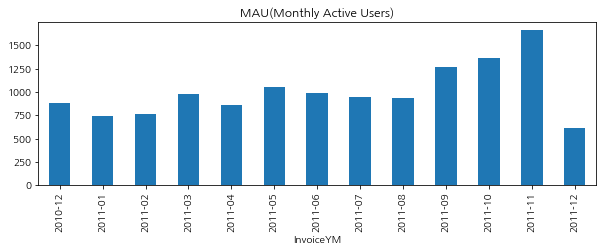

In [21]:
## MAU 구하기 
MAU = df_valid.groupby('InvoiceYM')['CustomerID'].nunique()
print(MAU)
MAU.plot.bar(figsize=(10,3), title = 'MAU(Monthly Active Users)')

In [23]:
## 월별 구매건수, 구매제품 종류, 구매고객수, 평균 판매가격, 총 판매량, 총 판매액 
df_valid.groupby('InvoiceYM').agg({'InvoiceNo': 'count', 
                                   'StockCode': 'nunique', 
                                   'CustomerID': 'nunique', 
                                   'UnitPrice': 'mean', 
                                   'Quantity': 'sum', 
                                   'Total_price': 'sum'})

,InvoiceNo,StockCode,CustomerID,UnitPrice,Quantity,Total_price
InvoiceYM,,,,,,
2010-12,25670,2411,885,3.142953,311048,570422.730
2011-01,20988,2121,741,3.155834,348473,568101.310
2011-02,19706,2124,758,3.177686,265027,446084.920
2011-03,26870,2234,974,3.269996,347582,594081.760
2011-04,22433,2217,856,3.501247,291366,468374.331
2011-05,28073,2219,1056,3.615606,372864,677355.150
2011-06,26926,2339,991,3.142043,363014,660046.050
2011-07,26580,2351,949,2.838771,367360,598962.901
2011-08,26790,2356,935,2.944274,397373,644051.040
